In [108]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle, plotTrajectoriesFile, AdvectionRK4,ErrorCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from scipy.special import entr

In [109]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [110]:
def tu_mix(particle,fieldset,time):
    particle.depthe = particle.lat/fieldset.fact[time,particle.depth,particle.lat,particle.lon]
    particle.sshe = fieldset.ssh[time,particle.depth,particle.lat,particle.lon]
    particle.late = fieldset.V[time,particle.depth,particle.depthe,particle.lon]
    #particle.lato = fieldset.V[time,particle.depth,particle.lat,particle.lon]
    #particle.lat+= particle.dt*particle.late*1e-2

In [111]:
#Dat = pd.read_csv('ubcSSg3DwGridFields1hV19-05_9244_b1de_6bbd.csv')
depth=np.linspace(0,10,20)

In [112]:
d0 = 1
dt = 90
L = 2
day  = 86400
time = np.linspace(0,L*day,int(L*day/90))
omega = 2/day
ssh = 1*np.sin(time*omega*np.pi*2)
fact = (1+ssh/depth[-1])

dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)
U = Field('U', np.zeros((len(time),dep,dim), dtype=np.float32), time=time, lat=depth, lon = lon)
#V = Field('V', np.zeros((len(time),dep,dim), dtype=np.float32), time=time, lat=depth,lon = lon)
V = np.ones((len(time),dep,dim), dtype=np.float32)
fact_data = np.ones((len(time),dep,dim), dtype=np.float32)
ssh_data = np.ones((len(time),dep,dim), dtype=np.float32)
for i in range(len(time)):
    V[i,:,:]=V[i,:,:]*fact[i]
    fact_data[i,:,:]=fact_data[i,:,:]*fact[i]
    ssh_data[i,:,:]=ssh_data[i,:,:]*ssh[i]
for i,d in enumerate(depth):
    V[:,i,:]= V[:,i,:]*d/10  
factor = Field('fact', fact_data, grid=U.grid)
ssh = Field('ssh', ssh_data, grid=U.grid)
V = Field('V', V, grid=U.grid)

In [113]:
class MPParticle(JITParticle):
    depthe = Variable('depthe', initial =  0) 
    sshe = Variable('sshe', initial =  0) 
    late = Variable('late', initial =  0) 
    lato = Variable('lato', initial =  0) 

In [114]:
fieldset = FieldSet(U, V)
fieldset.add_field(factor)
fieldset.add_field(ssh)

In [115]:
lon_g = np.ones((10*dim))*1e3#np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))

In [116]:
def run_turb_test(depth_g,lon_g):
    pset = ParticleSet(fieldset, pclass=MPParticle,lat=depth_g,lon=lon_g)
    output_file = pset.ParticleFile(name='Output.nc', outputdt=50)
    KE= pset.Kernel(tu_mix)
    pset.execute(KE , runtime=time[-1], dt=dt, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    output_file.export()  # export the trajectory data to a netcdf file

In [117]:
run_turb_test(depth_g,lon_g)


INFO: Compiled ArrayMPParticletu_mix ==> /var/folders/y1/__7_22kx3n9_rh91qk2htyc00000gn/T/parcels-501/lib98ce02a91a3ade57f9afae1f8593e990_0.so


Particle 6030 lost !! [21650.0, 0.0, 9.994795799255371, 1000.0]
Particle 6226 lost !! [21700.0, 0.0, 9.989781379699707, 1000.0]
Particle 6646 lost !! [21700.0, 0.0, 9.989706993103027, 1000.0]
Particle 6023 lost !! [21750.0, 0.0, 9.981188774108887, 1000.0]
Particle 6357 lost !! [21750.0, 0.0, 9.979912757873535, 1000.0]
Particle 6455 lost !! [21800.0, 0.0, 9.971980094909668, 1000.0]
Particle 6692 lost !! [21850.0, 0.0, 9.969932556152344, 1000.0]
Particle 6411 lost !! [21900.0, 0.0, 9.957225799560547, 1000.0]
Particle 6079 lost !! [21950.0, 0.0, 9.956026077270508, 1000.0]
Particle 6291 lost !! [21950.0, 0.0, 9.951930046081543, 1000.0]
Particle 6881 lost !! [21950.0, 0.0, 9.951743125915527, 1000.0]
Particle 6580 lost !! [22000.0, 0.0, 9.9420747756958, 1000.0]
Particle 6312 lost !! [22150.0, 0.0, 9.920355796813965, 1000.0]
Particle 6052 lost !! [22200.0, 0.0, 9.91620922088623, 1000.0]
Particle 6125 lost !! [22200.0, 0.0, 9.91728687286377, 1000.0]
Particle 6492 lost !! [22200.0, 0.0, 9.91869

INFO: Temporary output files are stored in out-HYJGPMOO.
INFO: You can use "parcels_convert_npydir_to_netcdf out-HYJGPMOO" to convert these to a NetCDF file during the run.
100%|██████████| 172800.0/172800.0 [00:26<00:00, 6487.29it/s] 


In [118]:
dat = xr.load_dataset('Output.nc')

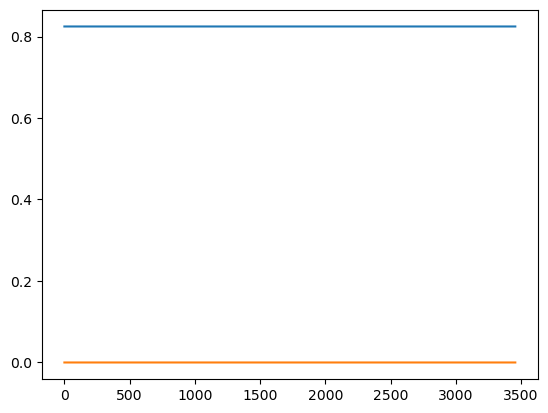

In [119]:
plt.plot(dat.late[1,1:].T)
plt.plot(dat.lato[1,1:].T)
#plt.plot(dat.lon[:,1].T)

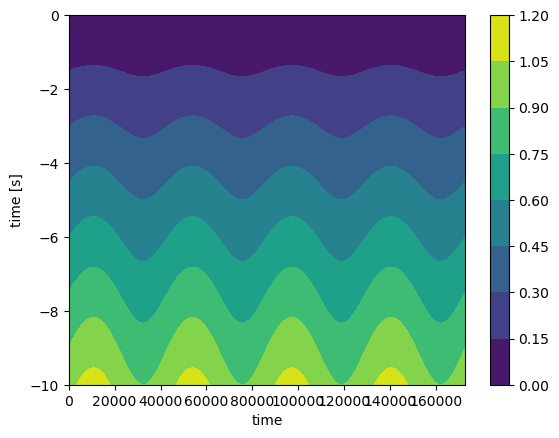

In [120]:
V = np.ones((len(time),dep,dim), dtype=np.float32)
for i in range(len(time)):
    V[i,:,:]=V[i,:,:]*fact[i]
for i,d in enumerate(depth):
    V[:,i,:]= V[:,i,:]*d/10    
plt.contourf(time,-depth,V[:,:,0].T)
plt.xlabel('time')
plt.ylabel('time [s]')
plt.colorbar()

In [121]:
def anim2(file1,file2,fps=1):  
    box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,2,figsize=(15,10))
    #axs[0].scatter(dat.lon[:,0],dat.lat[:,0],s=5)
    axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    axs[1].plot(box[0],box[1],c='grey',linewidth=3)
    axs[0].invert_yaxis()
    axs[0].set_title("Without using e3t correction")
    axs[1].invert_yaxis()
    axs[1].set_title("Using e3t correction")
    axs[0].set_ylabel('Depth (m)')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]                    
        ss.append(axs[1].scatter(file1.lon[:,frame],file1.lat[:,frame],s=5,c ='tab:blue'))    
        ss.append(axs[0].scatter(file2.lon[:,frame],file2.lat[:,frame],s=5,c ='tab:blue'))                           
        print(f'{frame/len(file1):.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(time),fps))

0.00% completed
0.00% completed
11.11% completed
22.22% completed
33.33% completed
44.44% completed
55.56% completed
66.67% completed
77.78% completed
88.89% completed
100.00% completed
111.11% completed
122.22% completed
133.33% completed
144.44% completed
155.56% completed
166.67% completed
177.78% completed
188.89% completed
200.00% completed
211.11% completed
0.00% completed


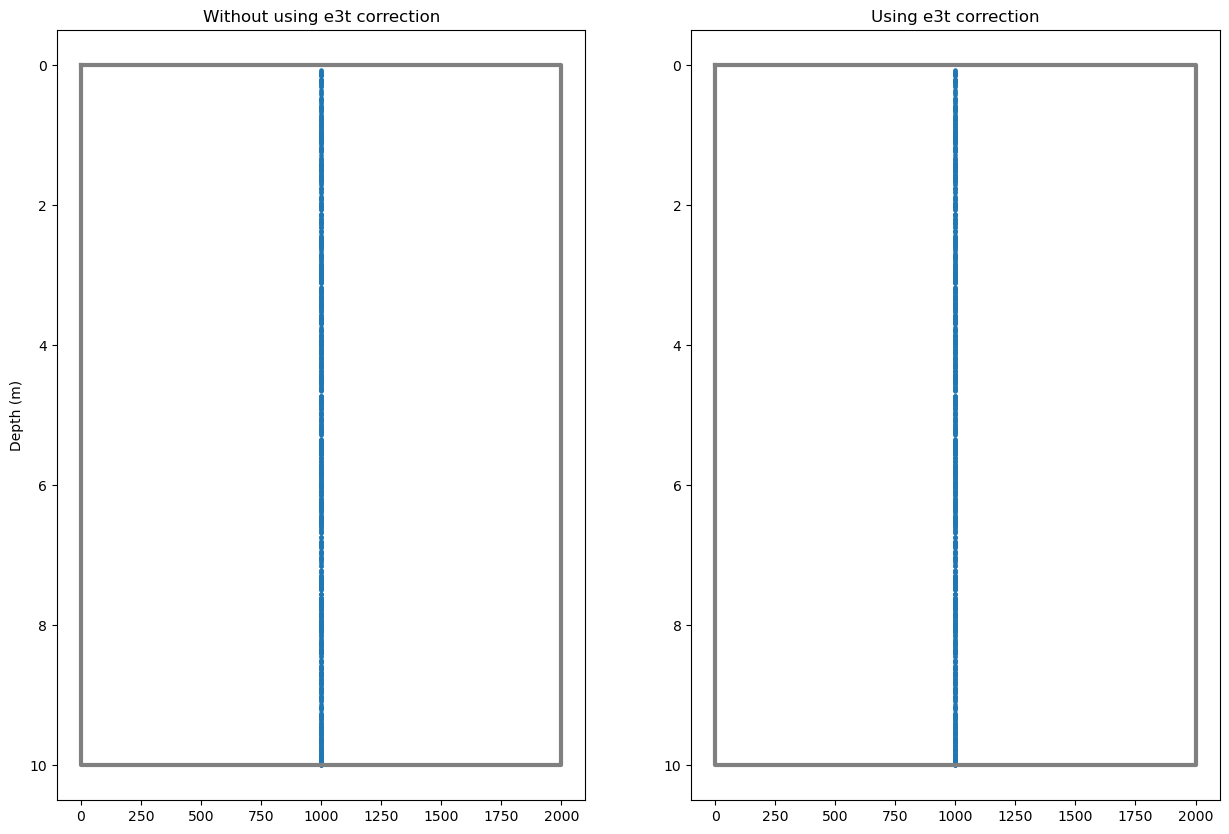

In [122]:
ss =[]
ani = anim2(dat,dat,fps=100)
f = r"/Users/jvalenti/Downloads/mix.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

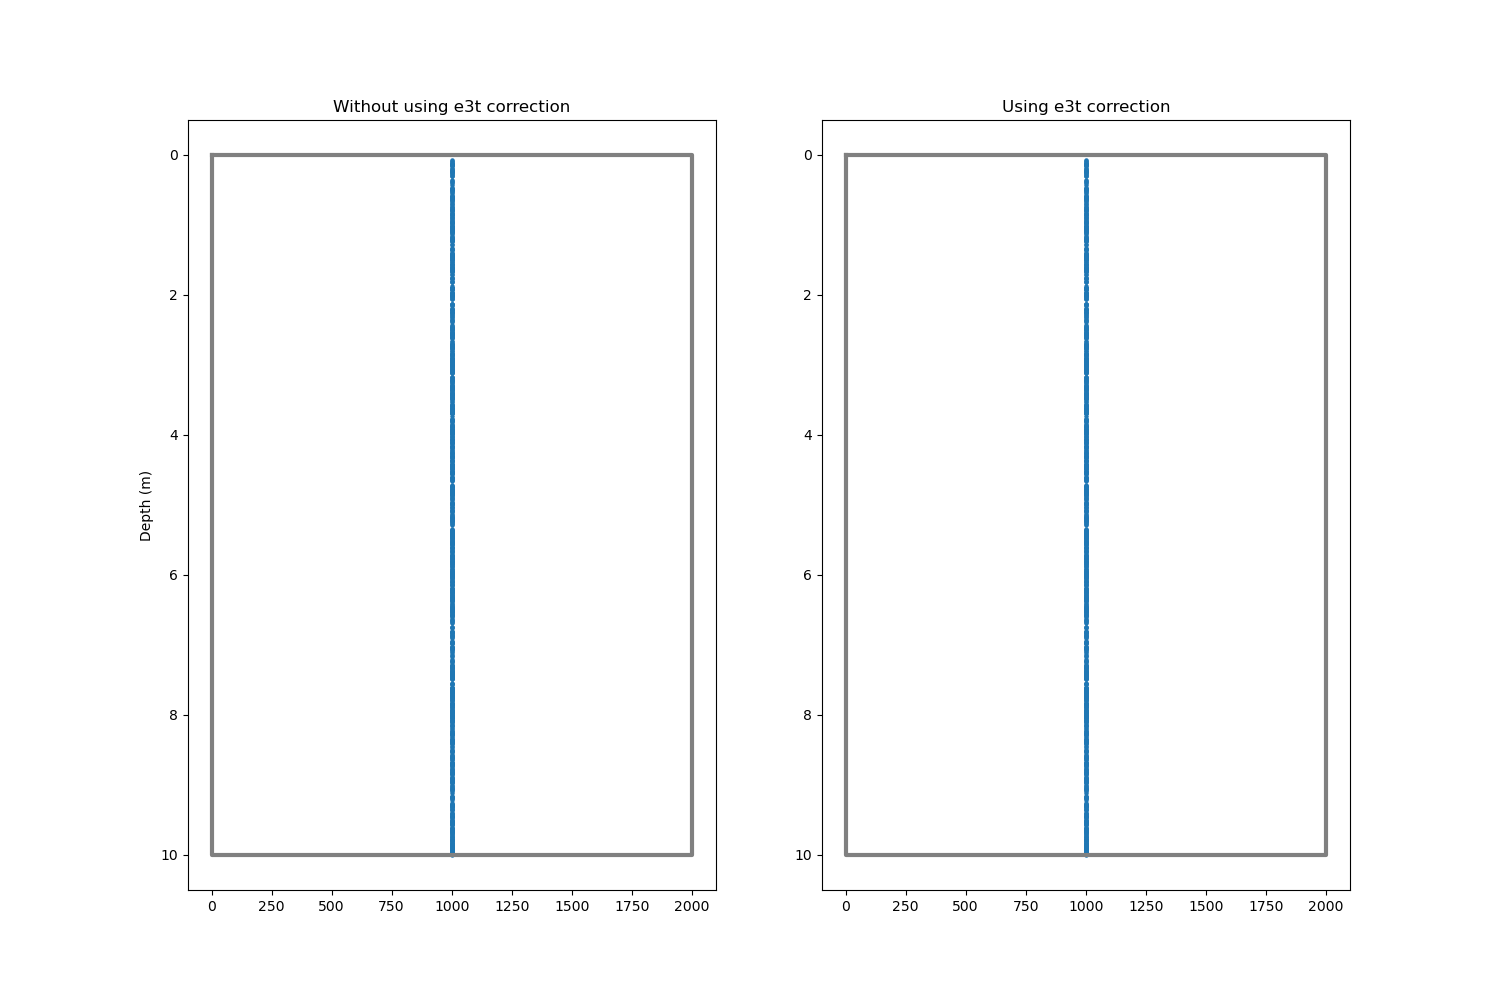

In [123]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))